In [1]:
from fastai.text import *

In [72]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def calc_cat1(answers, truth):
    # (1/n)*(nc+(nu*nc/n))
    n_correct = 0
    n_undecided = 0
    n = len(answers)
    for k, v in enumerate(answers):
        if v == 0.5:
            n_undecided += 1
        else:
            n_correct += (v > 0.5) == truth[k]

    scale = 1.0 / n
    return (n_correct + n_undecided * n_correct * scale) * scale

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.set_device('cuda:0')

In [5]:
df_train = pd.read_pickle('./data_new/pan_14e_cls/train_essays.pickle')
df_test01 = pd.read_pickle('./data_new/pan_14e_cls/test01_essays.pickle')
df_test02 = pd.read_pickle('./data_new/pan_14e_cls/test02_essays.pickle')
df_train

,label,k_doc,u_doc
0,Y,"[ English, my English! xcrlfx Assesing ones ...","In the name of Religion, you can get away wit..."
1,Y,[ English as a world language 1. xcrlfx Intr...,The Decline of the Birth-rate in Sweden A ne...
2,N,[ PART-TIME FATHERS When a relationship has i...,"""Taboo or Not Taboo"" In the article ""Cleanin..."
3,Y,[ Why Are the Young Abandoning Party Politics?...,Granting Homosexual Couples the Right to Adop...
4,N,[ Why do Swedish Women Wait with Having Childr...,Politics and Education On numerous occasions...
...,...,...,...
195,N,[I think I am quite fluent in English. xcrlfx...,Girls and boys in separate classes? xcrlfx ...
196,N,"[ My life, my choice It is forbidden in Swedi...","English, My English! xcrlfx Introduction: I..."
197,N,[When I first got this assignment I got really...,This an essay about my experience from studyin...
198,N,[ Should the US bomb Afghanistan? xcrlfx The...,\tJust a few years ago I felt quite confident ...


In [6]:
len(df_train), len(df_test01), len(df_test02)

(200, 100, 200)

In [11]:
uniq_list = []
for dfi, df in enumerate( [df_train, df_test01, df_test02] ):
    
    for i in range(len(df)):
        
        for doc in df.iloc[i,1]:
            if( doc not in uniq_list ):
                uniq_list.append(doc)
                
        if( df.iloc[i,2] not in uniq_list ):
            uniq_list.append( df.iloc[i,2] )

len(uniq_list)

1119

In [14]:
uniq_list = pd.DataFrame(uniq_list)
uniq_list

,0
0,"English, my English! xcrlfx Assesing ones s..."
1,Due to the increasing violence that we're dail...
2,"An peculiar lady crossed my path, once again!..."
3,"In the name of Religion, you can get away wit..."
4,English as a world language 1. xcrlfx Intro...
...,...
1114,In a country like Sweden the expectations of y...
1115,Canadian Television In Canada there are a wi...
1116,One thing about my English that I find particu...
1117,How does television affect children? xcrlfx...


In [15]:
db = TextLMDataBunch.from_df('./data_new/pan_13_cls/',
                            train_df=uniq_list[:850], valid_df=uniq_list[850:],
                            text_cols=0)

/home/aeryen/Code/04_Paper_AV/fastai/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [16]:
len( db.vocab.itos )

12032

## Train the LM

In [17]:
learn = language_model_learner(db, AWD_LSTM)

In [18]:
learn.unfreeze()
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy,time
0,4.261307,3.583425,0.328868,00:17
1,3.708321,3.397461,0.344207,00:17
2,3.508712,3.331704,0.350999,00:17
3,3.363652,3.296603,0.355558,00:18
4,3.256420,3.281622,0.356964,00:17
5,3.220381,3.280947,0.357403,00:18


## Show some text

In [19]:
learn.beam_search("And do your best to", 10)

'And do your best to And do your best to improve my English ? xcrlfx i do not think'

In [20]:
learn.predict( "Oh, if you only would. I'd just love", n_words=20 )

"Oh, if you only would. I'd just love making a portrait of Infact . xcrlfx Television has always been totally unthinkable in Sweden . xcrlfx"

# ============

In [49]:
def gen_ku_pairs(learn, k_doc, u_doc):
    model = learn.model
    model = model.eval()
    
    pred_enc = model[0]
    doc_enc = model[0].encoder
    
#     k_doc = df_test.iloc[0,1]
#     u_doc = df_test.iloc[0,2]
    
    k_ids, _ = learn.data.one_item(k_doc)
    u_ids, _ = learn.data.one_item(u_doc)
    
    with torch.no_grad():
        pred_enc.reset()
        k_embed = doc_enc(k_ids).detach()
        # we are using raw, dont care for dropout atm
        k_pred = pred_enc(k_ids)[0][-1].detach()
        
        pred_enc.reset()
        u_embed = doc_enc(u_ids).detach()
        u_pred = pred_enc(u_ids)[0][-1].detach()
        
        return k_embed, k_pred, u_embed, u_pred

In [29]:
def docmat_to_docvec(mat, reduce):
    if reduce == "mean":
        return mat.mean(dim=0)
    elif reduce == "max":
        return torch.max(mat, dim=0)[0]
    elif reduce == "meanmax":
        return torch.cat( [mat.mean(dim=0), torch.max(mat, dim=0)[0]] )

def pred_diff_reduce_cosine(learn, df, reduce="mean"):
    k_dv_list = []
    u_dv_list = []
    dist_list = []
    for i in range(len(df)):
        print(i)
        k_embed, k_pred, u_embed, u_pred = gen_ku_pairs(learn, df.iloc[i,1], df.iloc[i,2])
        k_dv = k_embed[0,1:,:] - k_pred[0,:-1,:]
        k_dv = docmat_to_docvec(k_dv, reduce)
        k_dv_list.append(k_dv.numpy())
        
        u_dv = u_embed[0,1:,:] - u_pred[0,:-1,:]
        u_dv = docmat_to_docvec(u_dv, reduce)
        u_dv_list.append(u_dv.numpy())
        
        dv_dist = torch.nn.functional.cosine_similarity(k_dv, u_dv, dim=0)
        dist_list.append(dv_dist.numpy())
        
    return  np.array(k_dv_list), np.array(u_dv_list), np.array(dist_list)

def pred_cosine_reduce_cosine(learn, df, reduce="mean"):
    k_dv_list = []
    u_dv_list = []
    dist_list = []
    for i in range(len(df)):
        print(i)
        k_embed, k_pred, u_embed, u_pred = gen_ku_pairs(learn, " ".join(df.iloc[i,1]), df.iloc[i,2])
        k_embed = k_embed[0,1:,:]
        k_pred = k_pred[0,:-1,:]
        cs1_values = torch.nn.functional.cosine_similarity(k_embed, k_pred, dim=1)
        cs1_sel = cs1_values < torch.median(cs1_values)
        k_dv = k_embed[cs1_sel,:] - k_pred[cs1_sel,:]
        k_dv = docmat_to_docvec(k_dv, reduce)
        k_dv_list.append(k_dv)
        
        u_embed = u_embed[0,1:,:]
        u_pred = u_pred[0,:-1,:]
        cs1_values = torch.nn.functional.cosine_similarity(u_embed, u_pred, dim=1)
        cs1_sel = cs1_values < torch.median(cs1_values)
        u_dv = u_embed[cs1_sel,:] - u_pred[cs1_sel,:]
        u_dv = docmat_to_docvec(u_dv, reduce)
        u_dv_list.append(u_dv)
        
        dv_dist = torch.nn.functional.cosine_similarity(k_dv, u_dv, dim=0)
        dist_list.append( dv_dist.cpu().numpy() )
        
    return  np.array(k_dv_list), np.array(u_dv_list), np.array(dist_list)

In [24]:
def get_dvs(learn, df):
    with torch.no_grad():
        k_dvs, u_dvs, dists = pred_cosine_reduce_cosine(learn, df)
    
    pred = dists > np.median(dists)
    truth = ( df["label"] == "Y" ).to_numpy()
    
    acc = np.sum( pred == truth ) / len(truth)
    print(acc)
    
    return k_dvs, u_dvs, dists

In [26]:
# Generate Training Set DV
train_k_dvs, train_u_dvs, train_dists = get_dvs(learn, df_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0.35


In [25]:
# Generate Eval Set DV
eval_k_dvs, eval_u_dvs, eval_dists = get_dvs(learn, df_test02)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0.33


# =====================================

In [50]:
def one_doc_embed(learn, doc):
    model = learn.model
    model = model.eval()
    
    pred_enc = model[0]
    doc_enc = model[0].encoder
    
    ids, _ = learn.data.one_item(doc)
    
    with torch.no_grad():
        pred_enc.reset()
        embed = doc_enc(ids).detach()
        pred  = pred_enc(ids)[0][-1].detach()
        
        return {"e":embed, "p":pred}

def pred_raw(learn, df):
    prob_list = []
    label_list = []
    with torch.no_grad():
        for i in range(len(df)):
            k_results = []
            for k_doc in df.iloc[i,1]:
                k_results.append( one_doc_embed(learn, k_doc) )

            u_results = one_doc_embed(learn, df.iloc[i,2])
            prob_list.append( {"k":k_results, "u":u_results} )
            label_list.append( df.iloc[i,0] )
        
    return  prob_list, label_list

In [51]:
test_prob, test_label = pred_raw(learn, df_test02)

In [52]:
test_prob[0]["k"][0]["e"][0,1:,:].shape

torch.Size([894, 400])

In [61]:
result_k = torch.nn.functional.cosine_similarity(test_prob[0]["k"][0]["e"][0,1:,:], test_prob[0]["k"][0]["p"][0,:-1,:], dim=1)
result_u = torch.nn.functional.cosine_similarity(test_prob[0]["u"]["e"][0,1:,:], test_prob[0]["u"]["p"][0,:-1,:], dim=1)
result_k.shape, result_u.shape

(torch.Size([894]), torch.Size([850]))

In [66]:
test_label[0]

'N'

/home/aeryen/anaconda3/envs/avpaper/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


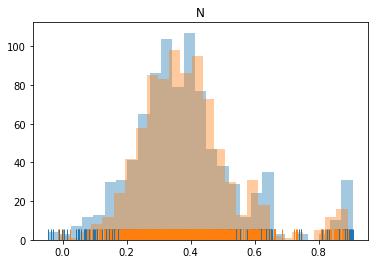

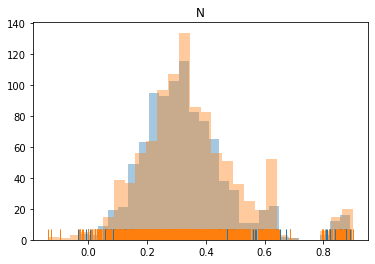

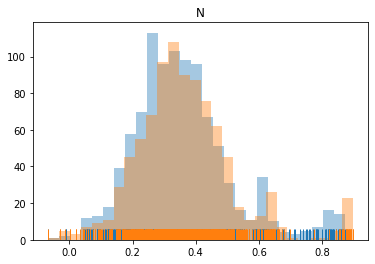

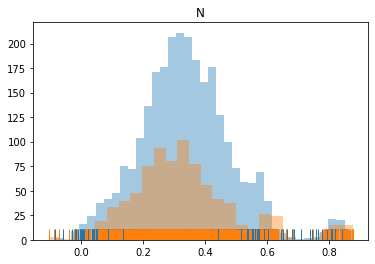

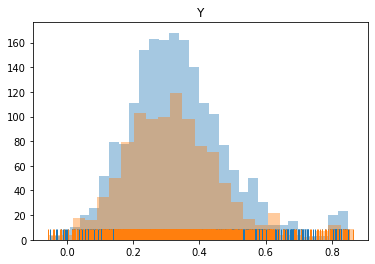

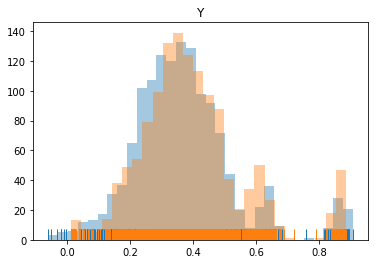

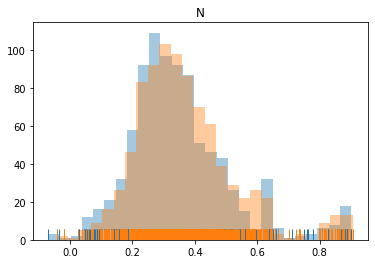

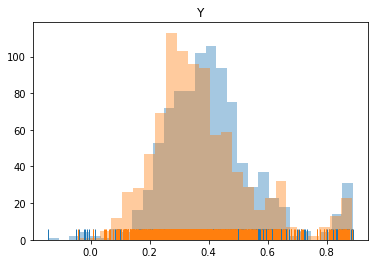

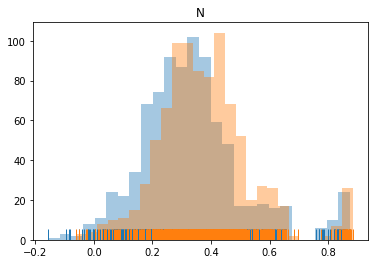

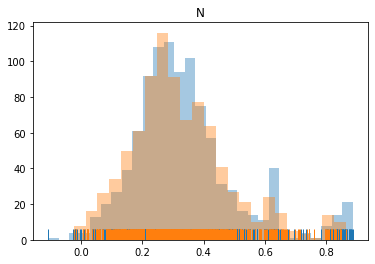

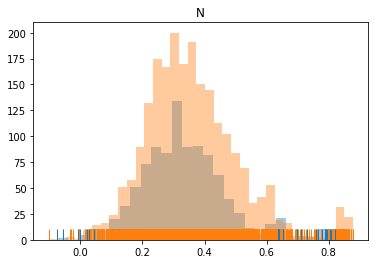

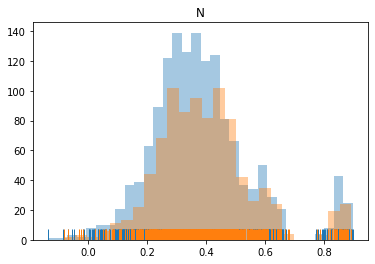

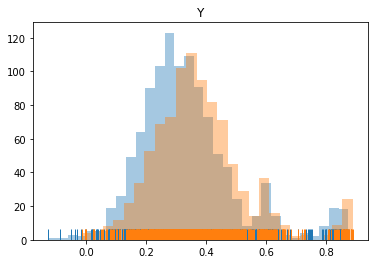

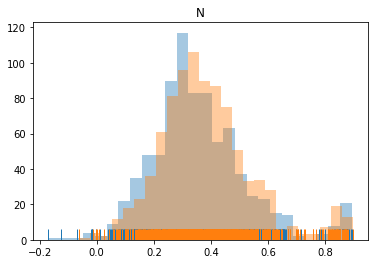

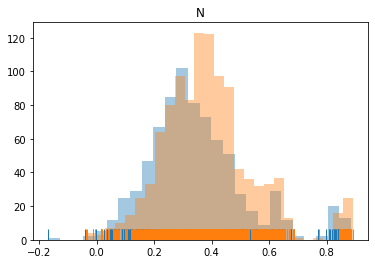

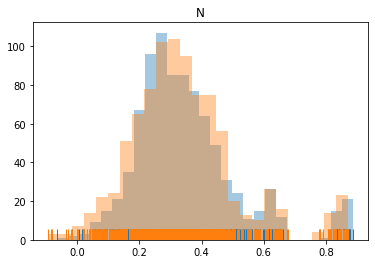

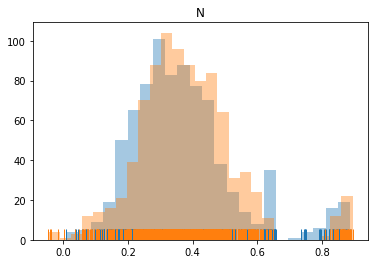

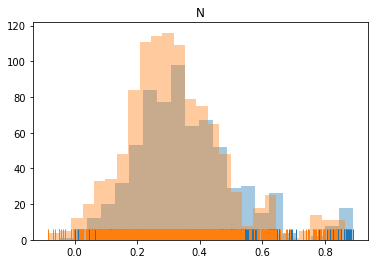

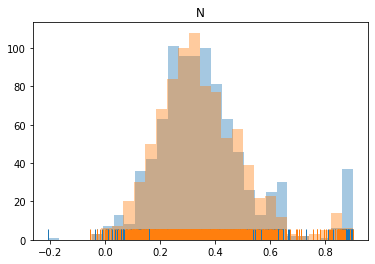

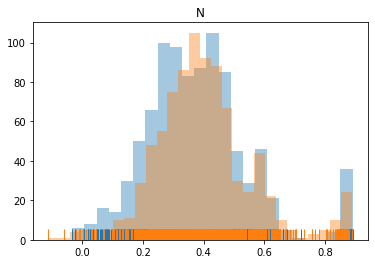

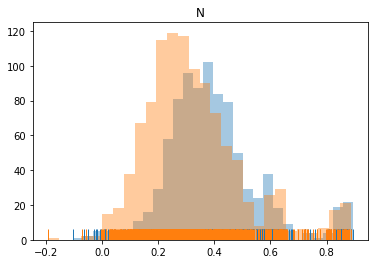

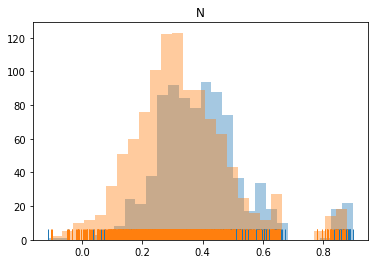

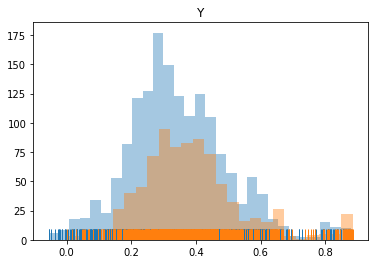

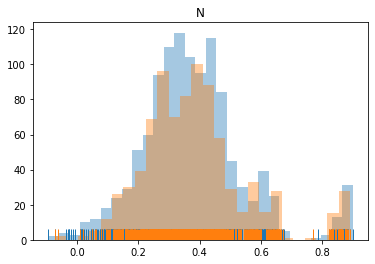

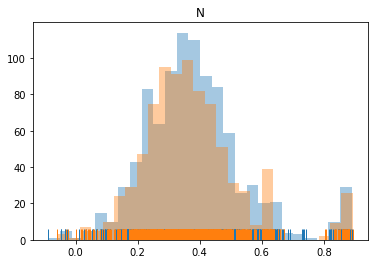

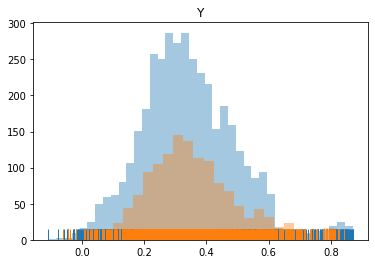

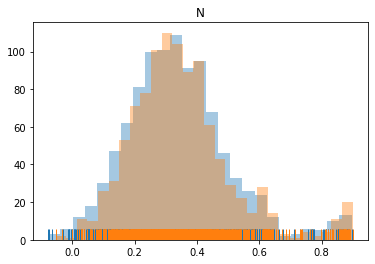

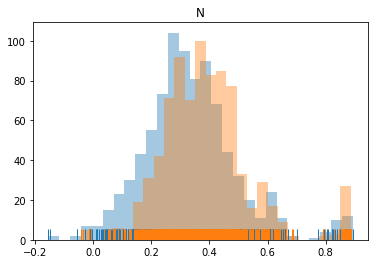

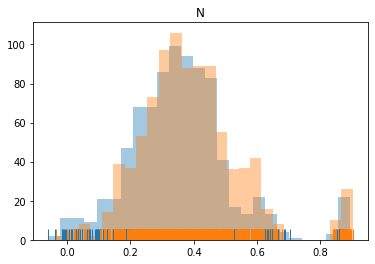

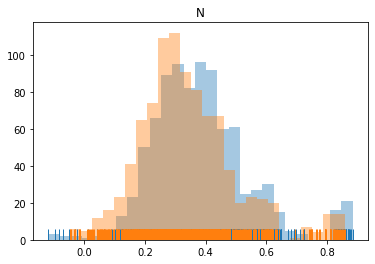

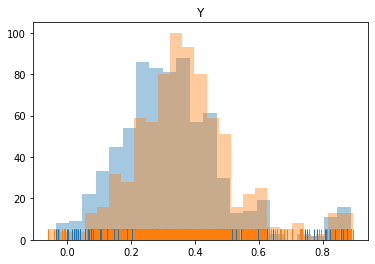

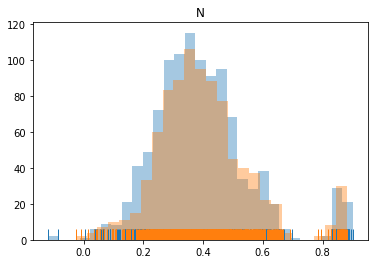

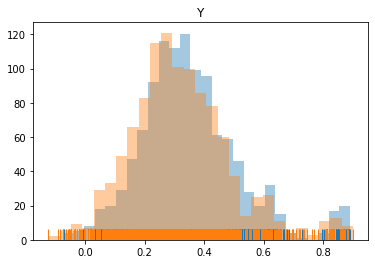

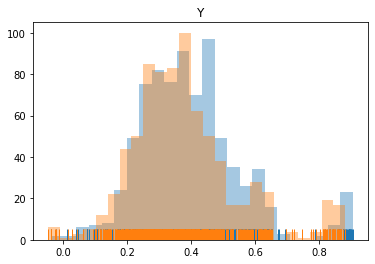

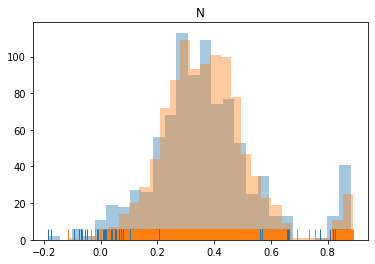

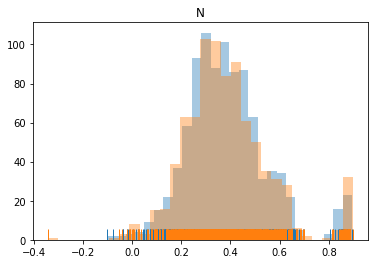

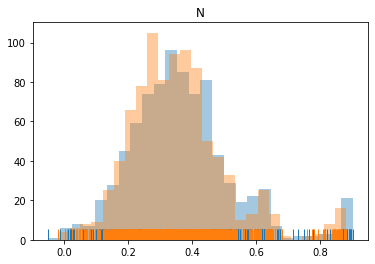

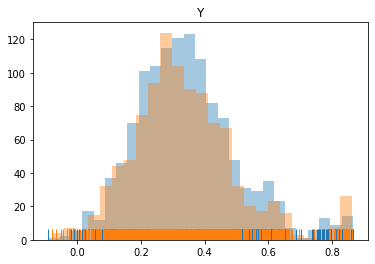

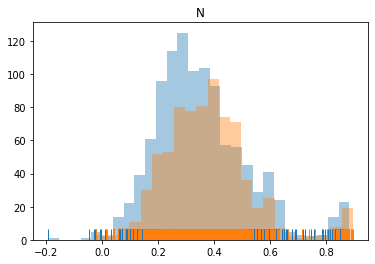

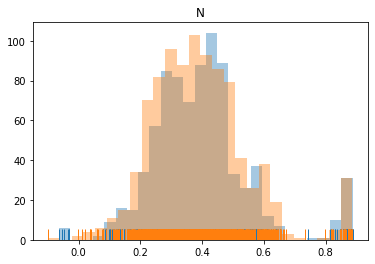

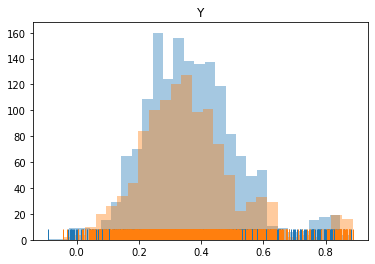

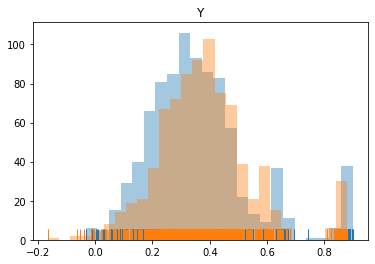

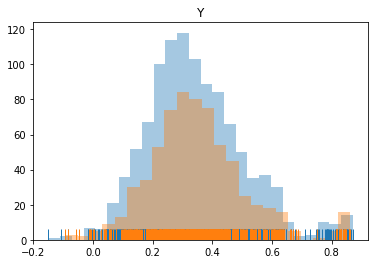

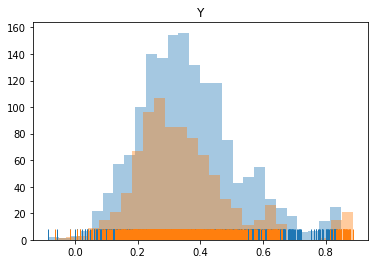

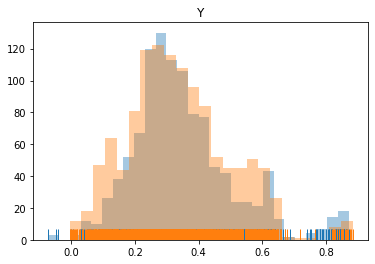

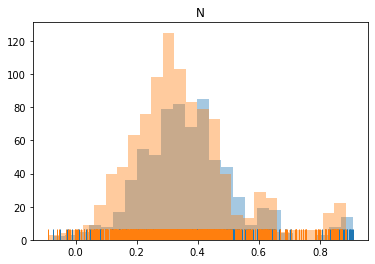

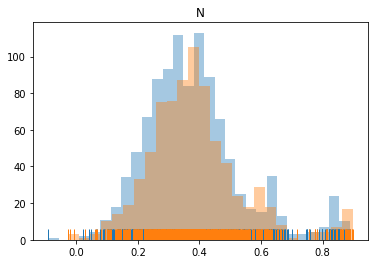

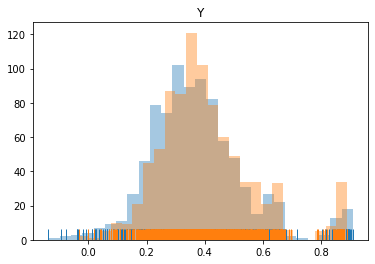

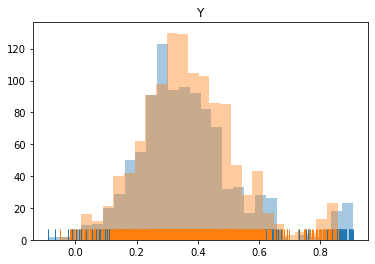

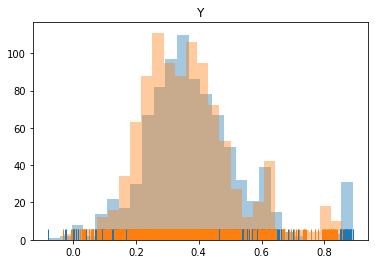

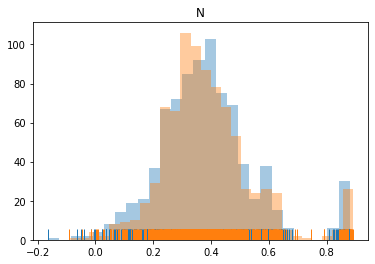

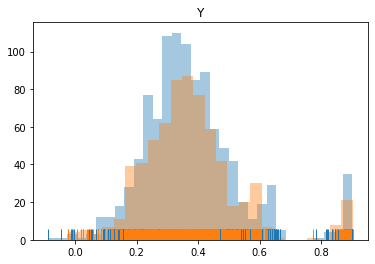

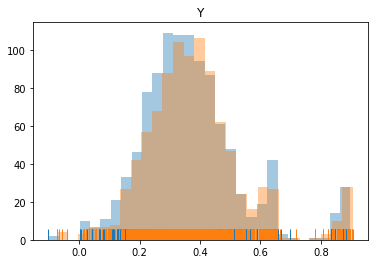

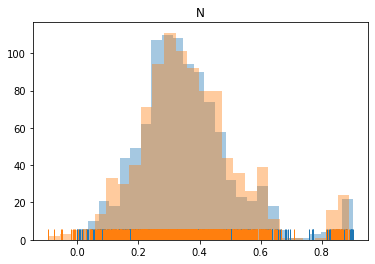

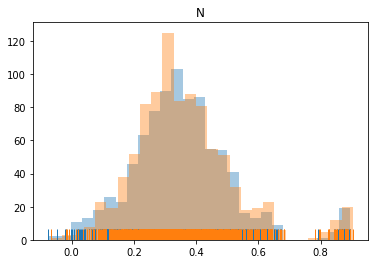

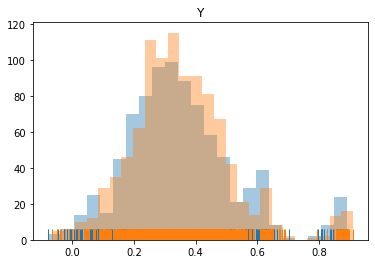

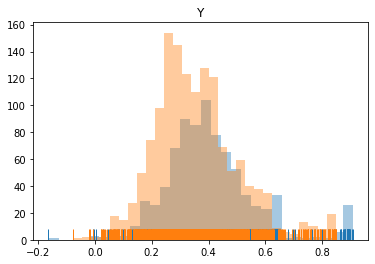

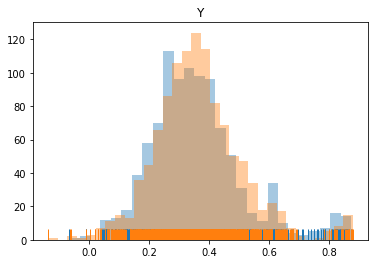

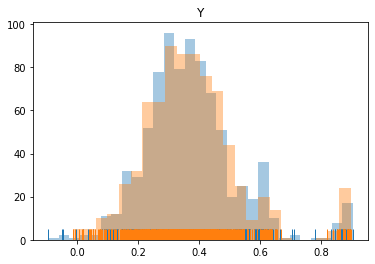

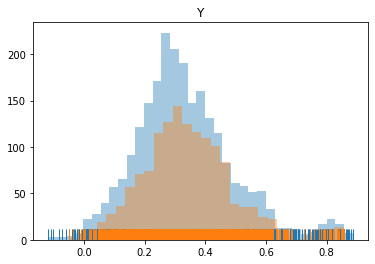

In [76]:
for i in range(60):
    result_k = torch.nn.functional.cosine_similarity(test_prob[i]["k"][0]["e"][0,1:,:], test_prob[i]["k"][0]["p"][0,:-1,:], dim=1)
    result_u = torch.nn.functional.cosine_similarity(test_prob[i]["u"]["e"][0,1:,:], test_prob[i]["u"]["p"][0,:-1,:], dim=1)
    
    fig = plt.figure()
    fig = sns.distplot(result_k.cpu().numpy(), kde=False, rug=True)
    fig = sns.distplot(result_u.cpu().numpy(), kde=False, rug=True)
    fig.set_title( test_label[i] )
    fig.figure.savefig(f'./dist_plot/{i:03}.png')

# ====================

In [45]:
train_y = ( df_train["label"].to_numpy() == "Y" ).astype(np.int)
# train_y = torch.tensor(train_y).cuda().double()
# train_y = train_y.unsqueeze(dim=-1)

eval_y = ( df_test["label"].to_numpy() == "Y").astype(np.int)
# eval_y = torch.tensor(eval_y).cuda().double()
# eval_y = eval_y.unsqueeze(dim=-1)

# =============================================

In [29]:
class ConcatClas(nn.Module):
    def __init__(self):
        super(ConcatClas, self).__init__()
        layer_1 = []
        layer_1.append( torch.nn.BatchNorm1d(400) )
        layer_1.append( torch.nn.Dropout(0.5) )
        layer_1.append( torch.nn.Linear(400, 1) )
#         layer_1.append( torch.nn.GELU() )
        self.l1 = nn.Sequential(*layer_1)
#         layer_2 = []
#         layer_2.append( torch.nn.BatchNorm1d(32) )
#         layer_2.append( torch.nn.Dropout(0.1) )
#         layer_2.append( torch.nn.Linear(32, 1) )
#         layer_2.append( torch.nn.Sigmoid() )
#         self.l2 = nn.Sequential(*layer_2)
        
    def forward(self, k_dv, u_dv):
#         dvs = torch.cat( (k_dv, u_dv), dim=1 )
        dvs = k_dv - u_dv
        t = self.l1(dvs)
#         t = self.l2(t)
        return t
        

In [30]:
def eval_acc(model, k_dvs, u_dvs, lbl):
    all_pred = []
    loss_list = []
    model.eval()
    with torch.no_grad():
        for i in range( int(len(lbl)/25) ):
#             print("step: " + str(i))
            xk = torch.tensor( k_dvs[(i*25):((i+1)*25), :] ).cuda()
            xu = torch.tensor( u_dvs[(i*25):((i+1)*25), :] ).cuda()
            y_pred = model(xk, xu)
            
            loss = F.binary_cross_entropy_with_logits(input=y_pred, target=lbl[(i*25):((i+1)*25), :])
            loss_list.append(loss.detach().cpu().numpy())
            
            all_pred.append( y_pred.detach().cpu().numpy() )
    all_pred = np.concatenate(all_pred)
    pred_tf = all_pred > np.median(all_pred)
    acc = np.sum( lbl.cpu().numpy() == pred_tf ) / len(lbl)
    print(acc)
    
    return all_pred, np.array(loss_list).mean()

In [36]:
model = ConcatClas()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
eval_loss = []
model = model.cuda()
for epoch in range(30):
    model.train()
    for i in range( int(len(train_y)/25) ):
        optimizer.zero_grad()
        xk = torch.tensor( train_k_dvs[(i*25):((i+1)*25), :] ).cuda()
        xu = torch.tensor( train_u_dvs[(i*25):((i+1)*25), :] ).cuda()
        y_pred = model(xk, xu)
        
        loss = F.binary_cross_entropy_with_logits(input=y_pred, target=train_y[(i*25):((i+1)*25), :])
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())
        print("train: " + str(train_loss[-1]) )

        
    pred, loss = eval_acc(model, eval_k_dvs, eval_u_dvs, eval_y)
    eval_loss.append( loss )
    print("+++ eval: " + str(loss) )
    
    


train: 0.7000899907926469
train: 0.7749779593576943
train: 0.8003144140471272
train: 0.8594630214691973
0.616
+++ eval: 0.6848077628953507
train: 0.6510298297324066
train: 0.6375039762816431
train: 0.7147838964734097
train: 0.8399711644655947
0.608
+++ eval: 0.6855422703241791
train: 0.5633849530655526
train: 0.6892517361957189
train: 0.7007255910174786
train: 0.8918429091905893
0.604
+++ eval: 0.6865546914885631
train: 0.5999261218325913
train: 0.7417572243118903
train: 0.6153397506026976
train: 0.7033520988370751
0.596
+++ eval: 0.6880841314252285
train: 0.5293864254045537
train: 0.6066917379194852
train: 0.7386041774167673
train: 0.7168000464856611
0.588
+++ eval: 0.6902702353424524
train: 0.542028308018409
train: 0.6203805042718236
train: 0.696202807958361
train: 0.7329040391839134
0.564
+++ eval: 0.6935402933014859
train: 0.5121326738864328
train: 0.6049202327820604
train: 0.6139946251959807
train: 0.6855665429182375
0.548
+++ eval: 0.6980374176456607
train: 0.4719082664271829
tra

In [57]:
pred

(500, 1)

In [38]:
len(train_loss)

40

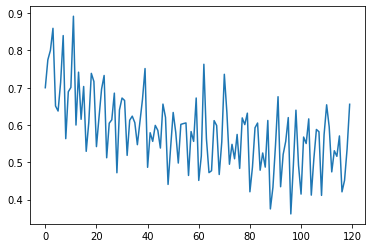

In [37]:
fig, ax = plt.subplots()
ax.plot(train_loss)
plt.show()

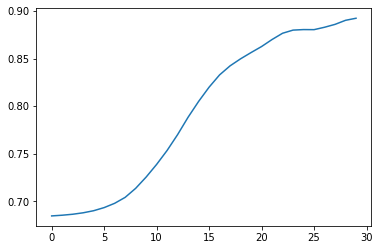

In [38]:
fig, ax = plt.subplots()
ax.plot(eval_loss)
plt.show()

# SVM =======================

In [41]:
from sklearn import svm

In [64]:
for kern in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = svm.SVC(kernel=kern)
    
    train_feat = np.concatenate([train_k_dvs-train_u_dvs, train_dists[:,None]], axis=1)
    clf.fit( train_feat, train_y )
    
    eval_feat = np.concatenate([eval_k_dvs-eval_u_dvs, eval_dists[:,None]], axis=1)
    pred_y = clf.predict( eval_feat )
    
    correct = pred_y == eval_y
    acc = sum(correct) / len(correct)
    print("kernel: " + kern + " acc: " + str(acc))

kernel: linear acc: 0.4666666666666667
kernel: poly acc: 0.4666666666666667
kernel: rbf acc: 0.6666666666666666
kernel: sigmoid acc: 0.5
